## Building a Model from Scratch

In [ ]:
# Installation of libraries and scikit
%pip install matminer --quiet
%pip install xgboost --quiet
%pip install scikit-learn --quiet

In [1]:
# Import of modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pprint
import seaborn as sns
plt.style.use('ggplot')

# Advanced
from pymatgen.core import Structure
import matminer
from matminer.datasets.dataset_retrieval import load_dataset
from monty.serialization import loadfn

## Data preparation

In [2]:
# Use matminer to load the dataset
df = load_dataset('matbench_log_kvrh')
print(f'The full dataset contains {df.shape[0]} entries. \n')


# Store the original DataFrame as a copy
full_dataset_df = df.copy()
# Create a subset of the original DataFrame for demonstration purposes
df = df.sample(n=1000, random_state=33)
print(f'Only work with {df.shape[0]} entries from the dataframe to make the model training and testing faster. \n')

print('The DataFrame is shown below:')
df.head(10)

The full dataset contains 10987 entries. 

Only work with 1000 entries from the dataframe to make the model training and testing faster. 

The DataFrame is shown below:


,structure,log10(K_VRH)
8056,"[[2.06897294 2.07140866 2.07140866] Rb, [0. 0....",1.806180
5435,"[[ 1.70008832 2.25388785 -1.56177691] O, [1.1...",1.255273
683,"[[1.95293774 1.38093552 3.38258738] O, [0. 0. ...",2.100371
292,"[[0. 0. 0.] N, [2.39230692 1.38119902 2.204841...",2.454845
8896,"[[0. 0. 0.] N, [-1.47701996e-08 1.70551574e+0...",2.528917
7903,"[[0. 0. 0.] Na, [3.03138537 3.03138537 3.03138...",1.113943
2774,"[[2.63855017 3.11606198 6.90394601] O, [3.0438...",1.591065
1707,"[[ 5.88340266 3.08816028 -2.12851027] Li, [ 2...",2.017033
10860,"[[4.5300617 1.49127167 7.84629702] O, [2.9160...",1.662758
9022,"[[3.51673412 0. 1.28204684] Si, [1.172...",2.426511


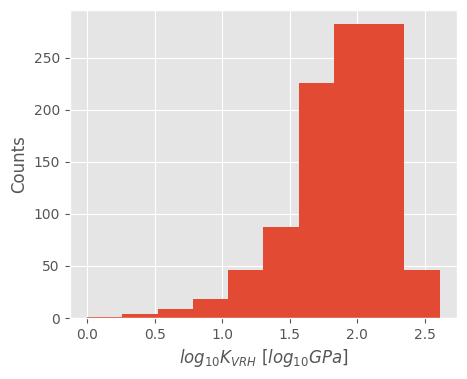

In [3]:
# Plot a histogram of values
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(df['log10(K_VRH)'])
ax.set_xlabel(r'$log_{10}K_{VRH}$ [$log_{10}GPa$]' )
ax.set_ylabel('Counts')
plt.show()

In [4]:
# Use matminer to featurise the dataset
from matminer.featurizers.composition.composite import ElementProperty
from matminer.featurizers.structure.order import DensityFeatures

# Add a composition column to df using the composition property of the Structure class
df['composition'] = df.structure.apply(lambda x: x.composition )

# Create the ElementProperty featuriser
el_prop_featuriser = ElementProperty.from_preset(preset_name='magpie')

# By default multiprocessing is enabled, however, this can slow performance, so we disable it
el_prop_featuriser.set_n_jobs(1)

# Featurise using the ElementProperty featuriser
df = el_prop_featuriser.featurize_dataframe(df, col_id='composition', pbar=False)

# Add structure features
density_featuriser = DensityFeatures()
density_featuriser.set_n_jobs(1)
df = density_featuriser.fit_featurize_dataframe(df, col_id='structure', pbar=False)

# Print the shape of the DataFrame
print(df.shape)
df.head()

(1000, 138)


,structure,log10(K_VRH),composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,density,vpa,packing fraction
8056,"[[2.06897294 2.07140866 2.07140866] Rb, [0. 0....",1.806180,"(Rb, Cu, F)",9.0,37.0,28.0,18.600000,11.520000,9.0,4.0,...,0.0,15.0,229.0,214.0,99.800000,101.760000,15.0,4.816804,14.203859,0.932682
5435,"[[ 1.70008832 2.25388785 -1.56177691] O, [1.1...",1.255273,"(O, Cs)",8.0,55.0,47.0,23.666667,20.888889,8.0,5.0,...,0.0,12.0,229.0,217.0,84.333333,96.444444,12.0,3.732206,24.456488,1.028108
683,"[[1.95293774 1.38093552 3.38258738] O, [0. 0. ...",2.100371,"(O, Cd)",8.0,48.0,40.0,28.000000,20.000000,8.0,70.0,...,0.0,12.0,194.0,182.0,103.000000,91.000000,12.0,7.791431,13.683654,0.603030
292,"[[0. 0. 0.] N, [2.39230692 1.38119902 2.204841...",2.454845,"(N, Cr)",7.0,24.0,17.0,18.333333,7.555556,24.0,49.0,...,0.0,194.0,229.0,35.0,217.333333,15.555556,229.0,6.723826,9.713804,0.828320
8896,"[[0. 0. 0.] N, [-1.47701996e-08 1.70551574e+0...",2.528917,"(N, Ta)",7.0,73.0,66.0,40.000000,33.000000,7.0,48.0,...,0.0,194.0,229.0,35.0,211.500000,17.500000,194.0,14.763854,10.963590,0.634847


Features should be standardised to make them more comparable. This is a common practice in machine learning, especially when using algorithms sensitive to feature magnitudes.

`MinMaxScaler` is a data scaling technique to transform numerical features within the range [0, 1]. It linearly scales data, preserving relationships between values, making it suitable for algorithms sensitive to feature magnitudes.

Finally, the dataset will be splitted into the target variable `log10(K_VRH)` and the input features. For the input features, any non-numerical data must be removed to avoid getting errors later in our workflow.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Define the features we want
features_to_drop = ['structure','composition','log10(K_VRH)']
feature_cols = [col for col in list(df.columns) if col not in features_to_drop]

# Get an array of the features
X = df[feature_cols].values

# Scale the feature columns
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

# Get an array of the target variable
y = df['log10(K_VRH)'].values

print(f'Shape of X: {X.shape}')
print(f'Shape of scaled_X: {scaled_X.shape}')
print(f'Shape of y: {y.shape}')

[[ 9.         37.         28.         ...  4.81680362 14.20385949
   0.93268153]
 [ 8.         55.         47.         ...  3.73220595 24.45648823
   1.02810801]
 [ 8.         48.         40.         ...  7.7914308  13.68365397
   0.60303008]
 ...
 [15.         63.         48.         ...  6.19856488 23.50654294
   0.56236676]
 [34.         92.         58.         ...  9.67827126 25.09262542
   0.55248602]
 [ 7.         27.         20.         ...  3.65306169 15.19166172
   0.80919043]]
[[0.09756098 0.37362637 0.32183908 ... 0.19888162 0.09383967 0.69369436]
 [0.08536585 0.57142857 0.54022989 ... 0.1480519  0.21464623 0.76917742]
 [0.08536585 0.49450549 0.45977011 ... 0.33828766 0.0877101  0.43293761]
 ...
 [0.17073171 0.65934066 0.55172414 ... 0.26363793 0.20345304 0.40077262]
 [0.40243902 0.97802198 0.66666667 ... 0.42671453 0.22214183 0.39295689]
 [0.07317073 0.26373626 0.22988506 ... 0.1443428  0.10547893 0.59601199]]
Shape of y: (1000,)


## Model choice


Random Forest is not sensitive to feature scaling because this model works by averaging over multiple decision trees, and the decision boundaries are determined by feature thresholds, not their absolute values.

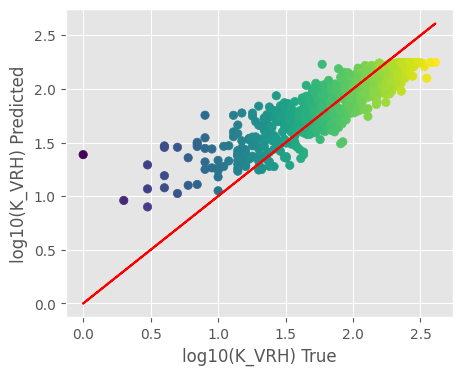

The training MAE = 0.136 log10GPa
The training RMSE = 0.187 log10GPa
The training r^2 = 0.742


In [ ]:
# Random forest - original features
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# Define the model
rf = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=3, min_samples_split=2, min_samples_leaf=1, random_state=412)

# Fit the model
rf.fit(X, y)

# Wrap the lines of code for later sections
def make_prediction_plot(X, y, model, label):
    y_pred = model.predict(X)  # Calculate predictions here
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.scatter(y, y_pred, c=y, cmap='viridis')
    ax.plot(y, y, 'r-')
    ax.set_xlabel(f'{label} True')
    ax.set_ylabel(f'{label} Predicted')
    plt.show()
    return y_pred  # Return y_pred

# Performance
y_pred = make_prediction_plot(X, y, rf, 'log10(K_VRH)')

print(f'The training MAE = {metrics.mean_absolute_error(y,y_pred):.3f} log10GPa')
print(f'The training RMSE = {np.sqrt(metrics.mean_squared_error(y,y_pred)):.3f} log10GPa')
print(f'The training r^2 = {rf.score(X,y):.3f}')

Like Random Forest, [XGBoost](https://xgboost.readthedocs.io) is an ensemble learning method. It uses a gradient-boosting framework and often achieves higher predictive accuracy by optimising for both bias and variance in the model.

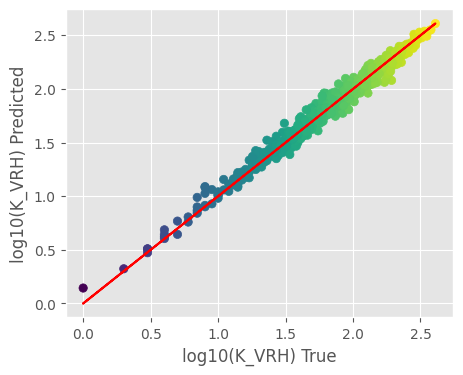

The training MAE = 0.035 log10GPa
The training RMSE = 0.048 log10GPa
The training r^2 = 0.983


In [ ]:
# XGBoost model
import xgboost as xgb

# Define the model
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=3, random_state=412, objective='reg:squarederror')

# Fit the model
xgb_model.fit(scaled_X, y)

# Performance
y_pred = make_prediction_plot(scaled_X, y, xgb_model, 'log10(K_VRH)')
print(f'The training MAE = {metrics.mean_absolute_error(y, y_pred):.3f} log10GPa')
print(f'The training RMSE = {np.sqrt(metrics.mean_squared_error(y, y_pred)):.3f} log10GPa')
print(f'The training r^2 = {xgb_model.score(scaled_X, y):.3f}')

XGBoost does a better job, but these models are likely to be overfit and unable to make useful predictions for new inputs.

## Training and testing

In [13]:
from sklearn.model_selection import train_test_split

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=412)

# Print the sizes of the arrays
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (800, 135)
y_train shape: (800,)
X_test shape: (200, 135)
y_test shape: (200,)


### Cross-validation

Using the 80% training set, a model can be trained by making use of [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html) in an attempt to avoid overfitting.

In [14]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Define models
xgb_model = XGBRegressor(n_estimators=100, max_depth=3, random_state=412, objective='reg:squarederror')
rf_model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=412)

# Perform cross-validation for XGBoost
xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
xgb_rmse = np.sqrt(-xgb_cv_scores)  # Convert to RMSE

# Perform cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rf_rmse = np.sqrt(-rf_cv_scores)  # Convert to RMSE

# Print results
# Compare the results
print("XGBoost Cross-Validation Results")
print(f"  Mean RMSE: {xgb_rmse.mean():.3f}")
print(f"  Standard Deviation of RMSE: {xgb_rmse.std():.3f}")

print("\nRandom Forest Cross-Validation Results")
print(f"  Mean RMSE: {rf_rmse.mean():.3f}")
print(f"  Standard Deviation of RMSE: {rf_rmse.std():.3f}")

XGBoost Cross-Validation Results
  Mean RMSE: 0.164
  Standard Deviation of RMSE: 0.020

Random Forest Cross-Validation Results
  Mean RMSE: 0.215
  Standard Deviation of RMSE: 0.031


### Hyperparamater optimisation

`GridSearchCV` can be used to automate tuning the hyperparameters, improving performance.

In [16]:
from sklearn.model_selection import GridSearchCV
from joblib import parallel_backend

# Hyperparameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.2]
}
with parallel_backend('threading'):	
	xgb_grid_search = GridSearchCV(XGBRegressor(random_state=412), xgb_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
	xgb_grid_search.fit(X_train, y_train)

	best_xgb_params = xgb_grid_search.best_params_
	best_xgb_model = xgb_grid_search.best_estimator_

# Hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'min_samples_split': [2, 4]
}

with parallel_backend('threading'):
	rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=412), rf_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
	rf_grid_search.fit(X_train, y_train)

	best_rf_params = rf_grid_search.best_params_
	best_rf_model = rf_grid_search.best_estimator_

# Evaluate the best models
xgb_cv_scores = -cross_val_score(best_xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
xgb_rmse = np.sqrt(xgb_cv_scores)

rf_cv_scores = -cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rf_rmse = np.sqrt(rf_cv_scores)

# Compare the results of the best models
print("Best XGBoost Hyperparameters:", best_xgb_params)
print("Best XGBoost Cross-Validation Results")
print(f"  Mean RMSE: {xgb_rmse.mean():.3f}")
print(f"  Standard Deviation of RMSE: {xgb_rmse.std():.3f}")

print("\nBest Random Forest Hyperparameters:", best_rf_params)
print("Best Random Forest Cross-Validation Results")
print(f"  Mean RMSE: {rf_rmse.mean():.3f}")
print(f"  Standard Deviation of RMSE: {rf_rmse.std():.3f}")

Best XGBoost Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best XGBoost Cross-Validation Results
  Mean RMSE: 0.156
  Standard Deviation of RMSE: 0.017

Best Random Forest Hyperparameters: {'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest Cross-Validation Results
  Mean RMSE: 0.174
  Standard Deviation of RMSE: 0.024


### Model assessment

Comparing test performance to training performance will help determine if the model generalises well or shows signs of overfitting or underfitting.

XGBoost test results:
RMSE: 0.145
R²: 0.841

Random Forest test results:
RMSE: 0.163
R²: 0.799


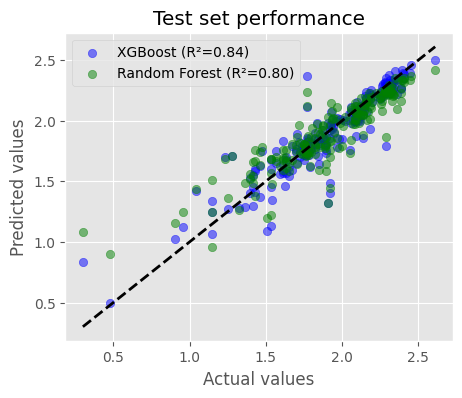

In [17]:
from sklearn.metrics import mean_squared_error, r2_score

# Test the best XGBoost model
xgb_test_preds = best_xgb_model.predict(X_test)
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_test_preds))
xgb_test_r2 = r2_score(y_test, xgb_test_preds)

# Test the best Random Forest model
rf_test_preds = best_rf_model.predict(X_test)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_preds))
rf_test_r2 = r2_score(y_test, rf_test_preds)

# Print test results
print("XGBoost test results:")
print(f"RMSE: {xgb_test_rmse:.3f}")
print(f"R²: {xgb_test_r2:.3f}")

print("\nRandom Forest test results:")
print(f"RMSE: {rf_test_rmse:.3f}")
print(f"R²: {rf_test_r2:.3f}")

# Create a scatter plot with both models in different colors
plt.figure(figsize=(5, 4))
plt.scatter(y_test, xgb_test_preds, c='blue', label=f'XGBoost (R²={xgb_test_r2:.2f})', alpha=0.5)
plt.scatter(y_test, rf_test_preds, c='green', label=f'Random Forest (R²={rf_test_r2:.2f})', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)  # Reference line (y=x)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Test set performance")
plt.legend()
plt.show()

XGBoost outperforms Random Forest in both cross-validation and test performance for this task, with the slight increase in RMSE from train to test suggesting both models generalise reasonably well.

### Model speed

The speed of a model may also be important, e.g. a use case involving millions of predictions. Several factors can influence the computational performance, including the dataset size, model complexity, and hardware. A simple comparison of our two models can be performed using `time`.

In [20]:
import time

# Measure the training time for XGBoost
start_time = time.time()
xgb_model.fit(X_train, y_train)
xgb_training_time = time.time() - start_time

# Measure the training time for Random Forest
start_time = time.time()
rf_model.fit(X_train, y_train)
rf_training_time = time.time() - start_time

# Measure the prediction time for XGBoost
start_time = time.time()
xgb_test_preds = xgb_model.predict(X_test)
xgb_prediction_time = time.time() - start_time

# Measure the prediction time for Random Forest
start_time = time.time()
rf_test_preds = rf_model.predict(X_test)
rf_prediction_time = time.time() - start_time

print(f"XGBoost training time: {xgb_training_time:.4f} seconds")
print(f"Random Forest training time: {rf_training_time:.4f} seconds")
print(f"\nXGBoost prediction time: {xgb_prediction_time:.4f} seconds")
print(f"Random Forest prediction time: {rf_prediction_time:.4f} seconds")

XGBoost training time: 0.0699 seconds
Random Forest training time: 0.6531 seconds

XGBoost prediction time: 0.0017 seconds
Random Forest prediction time: 0.0026 seconds


## Another Regression Model: Support Vector Regression

Support Vector Regression (SVR) is an extension of Support Vector Machines (SVM) for regression problems, used to predict continuous values.

**Core Concept**

* The goal of SVR is not to perfectly fit every data point, but to find an optimal curve within a tolerated error range.
* It introduces a parameter, **ϵ (epsilon-insensitive zone)**, which represents a margin within which the difference between predicted and true values is ignored.
* SVR only focuses on the points outside the epsilon margin. These points are called **support vectors**, and they determine the position of the regression curve.

**Key Features**

* Nonlinear modeling: Using a kernel function allows SVR to handle nonlinear relationships.
* Robustness: SVR is insensitive to a small number of outliers.
* Regularization: The internal parameter **C** controls model complexity, preventing overfitting.
* Feature scaling sensitivity: SVR is sensitive to the scale of the input features.


In [21]:
from sklearn.svm import SVR

X_train_scaled = scaler.fit_transform(X_train)

kernels = ['linear', 'rbf']
svr_results = {}

for kernel in kernels:
    svr_model = SVR(kernel=kernel)
    cv_scores = cross_val_score(svr_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    svr_results[kernel] = {
        'mean_rmse': rmse_scores.mean(),
        'std_rmse': rmse_scores.std()
    }

for kernel, metrics in svr_results.items():
    print(f"SVR ({kernel} kernel) - Mean RMSE: {metrics['mean_rmse']:.3f}, Std RMSE: {metrics['std_rmse']:.3f}")

SVR (linear kernel) - Mean RMSE: 0.179, Std RMSE: 0.033
SVR (rbf kernel) - Mean RMSE: 0.202, Std RMSE: 0.031
